<table width="100%">
  <tr>
    <td>
      <h1 style="text-align: left; font-size:300%;">Homework 2 - Time Series forecasting challenge</h1>
      <table align="left">
        <tr>
          <td style="text-align: left;">Bottazzi Daniele</td>
          <td style="text-align: left;"><a href="mailto:nouhaila.benhdidou@mail.polimi.it">daniele.bottazzi@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left;">Resta Sara</td>
          <td style="text-align: left;"><a href="mailto:daniele.bottazzi@mail.polimi.it">sara.resta@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left;">Saldarini Gaia</td>
          <td style="text-align: left;"><a href="mailto:annalisa.imperiali@mail.polimi.it">gaia.saldarini@mail.polimi.it</a></td>
        </tr>
      </table>
    </td>
    <td width="20%">
      <div style="text-align: right">
          <br>
        <b style="font-size: 120%;">AN2DL course</b><br>
        <b>a.y. 2023-2024</b>
          <br><br>
        prof. M. Matteucci<br>
        prof. G. Boracchi<br>
      </div>
    </td>
  </tr>
</table>

# Bidirectional LSTM with Attention

 Link to dowload the `filtered_datasets` used in this Notebook: [link](https://drive.google.com/drive/folders/1FuVLBucfEEDN3pPuNTSgjwv6_3Rstn_4?usp=sharing).

In this homework you are asked to predict future samples of the input time series. The goal is to design and implement forecasting models to learn how to exploit past observations in the input sequences to correctly predict the future. The task is to develop a forecasting model that is able to predict several uncorrelated time series.

The prerequisite is that the model exhibits generalisation capabilities in the forecasting domain, allowing it to transcend the constraints of specific time domains. This requires a model that, while specialised in forecasting, is not limited to predicting in a single or predefined time context.

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/AN2DL/2023-2024/Homework 2

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/AN2DL/2023-2024/Homework 2


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import seaborn as sns

### Load and preprocess the dataset

In [ ]:
# Conditional check for unzipping
unzip = False

# Unzip the 'training_dataset.zip' file if the 'unzip' flag is True
if unzip:
    !unzip training_dataset.zip

In [ ]:
# Load dataset
unique_series = np.load('filtered_datasets/filtered_series_02.npy')
unique_valid_periods = np.load('filtered_datasets/filtered_valid_periods_02.npy')
unique_categories = np.load('filtered_datasets/filtered_categories_02.npy')

In [ ]:
# Print the shapes of the loaded datasets
print("Training data Shape:", unique_series.shape)
print("Valid periods data Shape:", unique_valid_periods.shape)
print("Categories Shape:", unique_categories.shape)

Training data Shape: (47048, 2776)
Valid periods data Shape: (47048, 2)
Categories Shape: (47048,)


In [ ]:
# Normalization
print(np.any(unique_series < 0))
print(np.any(unique_series > 1))
print(np.min(np.max(unique_series, axis=0))) # must normalize in some way

False
False
0.15527808343460037


## Process data

In [ ]:
# Remove padding from unique seqies
valid_series = np.array([row[start:end+1] for row, (start, end) in zip(unique_series, unique_valid_periods)])
valid_series[0].shape

(25,)

In [ ]:
# Split into train_validation and test sets
series_train_val, series_test, categories_train_val, categories_test = train_test_split(valid_series, unique_categories, random_state=seed, test_size=0.1, stratify=unique_categories)

# Print shapes of the datasets
print(f"series_train_val shape: {series_train_val.shape}, categories_train_val shape: {categories_train_val.shape}")
print(f"series_test shape: {series_test.shape}, categories_test shape: {categories_test.shape}\n")

# See if stratification was succesful
print(np.unique(categories_train_val, return_counts = True))
print(np.unique(categories_test, return_counts = True))

series_train_val shape: (42343,), categories_train_val shape: (42343,)
series_test shape: (4705,), categories_test shape: (4705,)

(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'), array([5108, 9673, 8785, 8798, 9750,  229]))
(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'), array([ 568, 1075,  976,  978, 1083,   25]))


### Process data

In [ ]:
def build_sequences_univariate(series_array, categories, window=100, stride=20, telescope=18):
    # Sanity check to avoid runtime errors
    assert (window + telescope) % stride == 0
    sequences = []
    future_sequences = []
    seq_categories = []

    for (i, series) in enumerate(series_array):
        series_len = len(series)
        padding_check = series_len % (window + telescope)

        if padding_check != 0:
            # Compute padding length
            padding_len = (window + telescope) - series_len % (window + telescope)
            padding = np.zeros(padding_len, dtype='float32')

            series = np.concatenate((padding, series))
            assert len(series) % (window + telescope) == 0

        for idx in np.arange(0, len(series) - window, stride):

            # Get a slice of window + telescope of the series
            series_xy = series[idx:idx + window + telescope]

            # Get x
            series_x = series_xy[0:window]

            # Add to the sequences
            sequences.append(series_x)

            # Get y
            series_y = series_xy[window:window+telescope]

            # Add to future sequences
            future_sequences.append(series_y)

            # Append the category label
            seq_categories.append(categories[i])

    sequences = np.array(sequences)
    future_sequences = np.array(future_sequences)
    seq_categories = np.array(seq_categories)

    return sequences, future_sequences, seq_categories

In [ ]:
window = 180
stride = 22

In [ ]:
telescope = 18
direct_telescope = telescope

In [ ]:
X_train_val, y_train_val, seq_categories_train_val = build_sequences_univariate(series_train_val, categories_train_val, window = window, stride = stride, telescope = direct_telescope)

In [ ]:
print(series_train_val.shape)
print(categories_train_val.shape)
print(X_train_val.shape)
print(y_train_val.shape)
print(seq_categories_train_val.shape)

(42343,)
(42343,)
(260161, 180)
(260161, 18)
(260161,)


In [ ]:
X_test, y_test, seq_categories_test = build_sequences_univariate(series_test, categories_test, window = window, stride = stride, telescope = direct_telescope)

In [ ]:
print(series_test.shape)
print(categories_test.shape)
print(X_test.shape)
print(y_test.shape)
print(seq_categories_test.shape)

(4705,)
(4705,)
(30067, 180)
(30067, 18)
(30067,)


In [ ]:
# Split train_validation sequences into train and validation sets
X_train, X_val, y_train, y_val, seq_categories_train, seq_categories_val = train_test_split(X_train_val, y_train_val, seq_categories_train_val,
                                                                                            shuffle=True, random_state=seed, test_size=0.2, stratify=seq_categories_train_val)

In [ ]:
# Expand dimensions
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [ ]:
# Print shapes of the sequences datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, seq_categories_train shape: {seq_categories_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}, seq_categories_val shape: {seq_categories_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}, seq_categories_test shape: {seq_categories_test.shape}\n")

# See if stratification was succesful
print(np.unique(seq_categories_train, return_counts = True))
print(np.unique(seq_categories_val, return_counts = True))
print(np.unique(seq_categories_test, return_counts = True))

X_train shape: (208128, 180, 1), y_train shape: (208128, 18, 1), seq_categories_train shape: (208128,)
X_val shape: (52033, 180, 1), y_val shape: (52033, 18, 1), seq_categories_val shape: (52033,)
X_test shape: (30067, 180, 1), y_test shape: (30067, 18, 1), seq_categories_test shape: (30067,)

(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'), array([37228, 34623, 48399, 49756, 37046,  1076]))
(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'), array([ 9307,  8656, 12100, 12439,  9262,   269]))
(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'), array([5500, 4864, 7006, 6927, 5610,  160]))


### Univariate Forecating (Direct)

In [ ]:
def inspect_univariate(X, y, telescope, idx = 42):
    plt.plot(np.arange(len(X[idx])), X[idx])
    plt.scatter(np.arange(len(X[idx]), len(X[idx]) + telescope), y[idx], color='orange', s = 5)
    plt.ylim(0,1)
    plt.show()

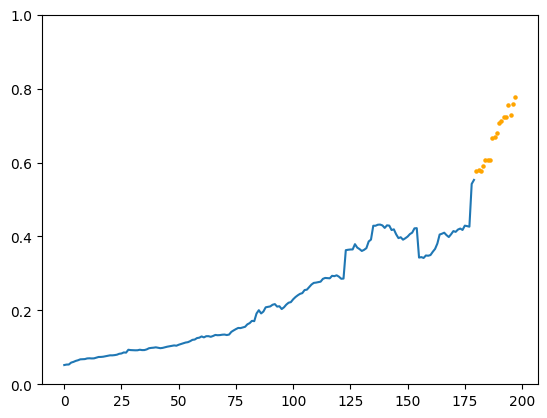

In [ ]:
inspect_univariate(X_train, y_train, direct_telescope, idx = 122)

In [ ]:
input_shape  = X_train.shape[1:]
output_shape = y_train.shape[1:]

batch_size = 1024
epochs = 200

In [ ]:
inputs = tfkl.Input(shape=input_shape, name='input_layer')

# LSTM layer
lstm_output = tfkl.LSTM(64, return_sequences=True, activation='relu')(inputs)

# Attention layer
attention_output = tfkl.MultiHeadAttention(num_heads=8, key_dim=1)(lstm_output, lstm_output, lstm_output)

# Additional layers after attention
dropout_1 = tfkl.Dropout(0.2, name='dropout_1')(attention_output)
lstm_2 = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True), name='bi_lstm_2')(dropout_1)
dropout_2 = tfkl.Dropout(0.2, name='dropout_2')(lstm_2)
output = tfkl.Dense(output_shape[0], name='dense')(dropout_2)

model = tfk.Model(inputs=inputs, outputs=output, name='bi_LSTM_model')

In [ ]:
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3))

Model: "bi_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 180, 1)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 180, 64)              16896     ['input_layer[0][0]']         
                                                                                                  
 multi_head_attention (Mult  (None, 180, 64)              2136      ['lstm[0][0]',                
 iHeadAttention)                                                     'lstm[0][0]',                
                                                                     'lstm[0][0]']                
                                                                                      

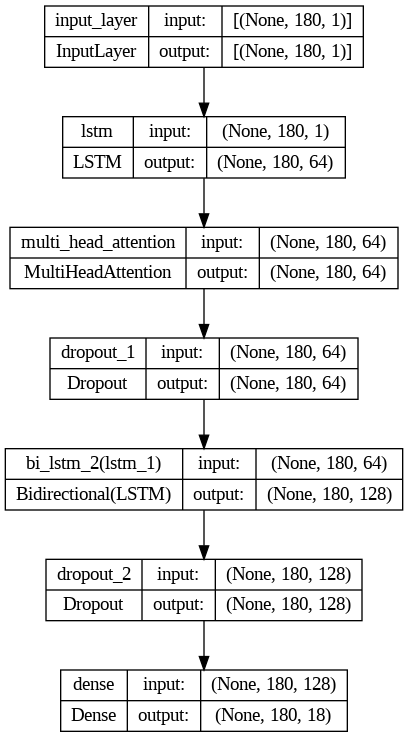

In [ ]:
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True,min_delta=1e-4),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.2, min_lr=1e-5,min_delta=1e-4)
    ]
).history

Epoch 1/200
204/204 [==============================] - 128s 360ms/step - loss: 0.1653 - val_loss: 0.1051 - lr: 0.0020
Epoch 2/200
204/204 [==============================] - 74s 362ms/step - loss: 0.1060 - val_loss: 0.0892 - lr: 0.0020
Epoch 3/200
204/204 [==============================] - 71s 349ms/step - loss: 0.0938 - val_loss: 0.0857 - lr: 0.0020
Epoch 4/200
204/204 [==============================] - 69s 340ms/step - loss: 0.0895 - val_loss: 0.0831 - lr: 0.0020
Epoch 5/200
204/204 [==============================] - 70s 342ms/step - loss: 0.0867 - val_loss: 0.0857 - lr: 0.0020
Epoch 6/200
204/204 [==============================] - 68s 334ms/step - loss: 0.0845 - val_loss: 0.0783 - lr: 0.0020
Epoch 7/200
204/204 [==============================] - 79s 388ms/step - loss: 0.0815 - val_loss: 0.0812 - lr: 0.0020
Epoch 8/200
204/204 [==============================] - 68s 335ms/step - loss: 0.0801 - val_loss: 0.0791 - lr: 0.0020
Epoch 9/200
204/204 [==============================] - 71s 347m

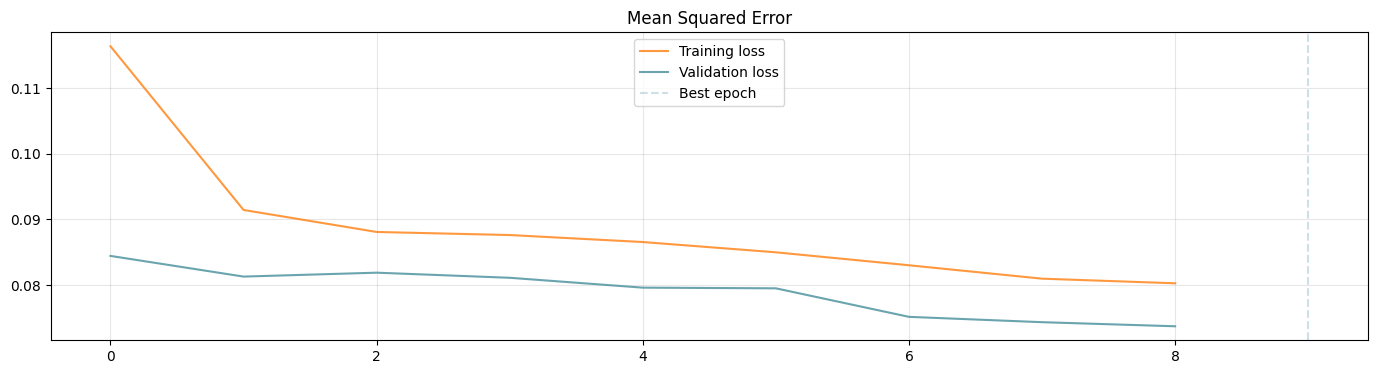

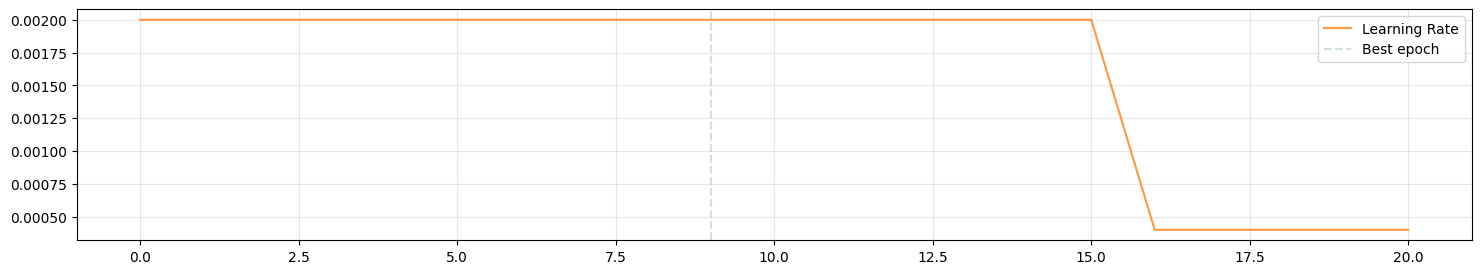

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('DirectForecasting_180_18_22_RLROP-factor-05_filt_02_stacked_conv_attention')

In [ ]:
model = tfk.models.load_model('DirectForecasting_180_18_22_RLROP-factor-05_filt_02_stacked_conv_attention')

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

In [ ]:
predictions_9 = predictions[:, 0:9]
# Print the shape of the predictions
print(f"Predictions shape: {predictions_9.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test[:, 0:9, :].flatten(), predictions_9.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test[:, 0:9, :].flatten(), predictions_9.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (30067, 9)
Mean Squared Error: 0.0075596654787659645
Mean Absolute Error: 0.051989372819662094


In [ ]:
# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (30067, 18)
Mean Squared Error: 0.010503952391445637
Mean Absolute Error: 0.06354103237390518


## `model.py`

In [ ]:
%%writefile model.py
import os
import tensorflow as tf

class model:
    def _init_(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X, categories):

        out = self.model.predict(X[:,-180:])  # Shape [BSx9] for Phase 1 and [BSx18] for Phase 2
        out = out.reshape(-1, 18)

        return out